## week0_09 practice: PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

/tmp/ipykernel_1913/57725513.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rho = (1 + 0.9 * np.cos(6 * theta)) * (1 + 0.01 * np.cos(24 * theta)) \
/tmp/ipykernel_1913/57725513.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  * (0.5 + 0.05 * np.cos(200 * theta)) * (10 + np.sin(10 * theta))
/tmp/ipykernel_1913/57725513.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = np.cos(rho)
/tmp/ipykernel_1913/57725513.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = np.sin(rho)


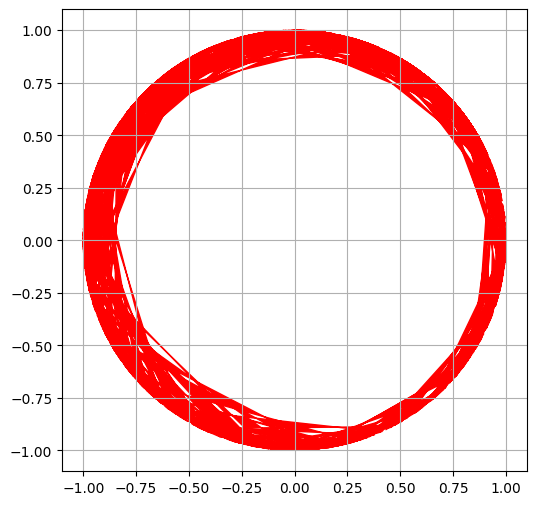

In [2]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * np.cos(6 * theta)) * (1 + 0.01 * np.cos(24 * theta)) \
 * (0.5 + 0.05 * np.cos(200 * theta)) * (10 + np.sin(10 * theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = np.cos(rho)
y = np.sin(rho)


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the Dataloader

In [2]:
from torch import nn
from torch.nn import functional as F

In [3]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/week0_08_dropout_batchnorm/notmnist.py -nc

File ‘notmnist.py’ already there; not retrieving.



In [4]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8259k  100 8259k    0     0  2355k      0  0:00:03  0:00:03 --:--:-- 2357k


Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [5]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [6]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [7]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [8]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

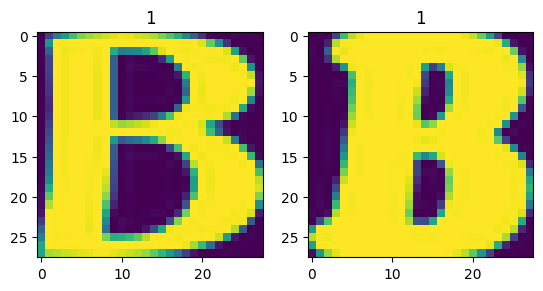

In [9]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [10]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [11]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [13]:
images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9561261..1.2348979].


Text(0.5, 1.0, '[0 1 0 0 1 1 0 1]')

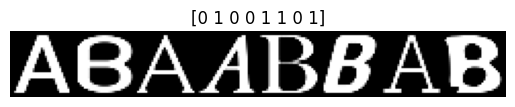

In [14]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy())

And now with transformations:

In [15]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [16]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [18]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = next(train_iter_tr)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9274819..1.2529621].


Text(0.5, 1.0, '[9 7 7 1 0 5 9 3]')

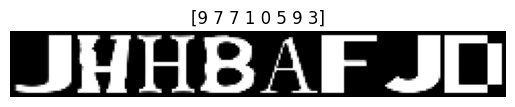

In [20]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy())

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [21]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [22]:
a = Flatten()

In [23]:
a(img).shape

torch.Size([784])

In [24]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [25]:
import time

from IPython.display import clear_output

In [26]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [27]:
def subset_ind(dataset, ratio: float):
#     return ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [28]:
dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [29]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2996
validation size: 748


In [30]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [32]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [44]:
loss_func = nn.CrossEntropyLoss()

In [45]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [46]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch = X_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)

            loss.backward()

            opt.step()

            opt.zero_grad()

            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            correct_predictions = 0
            total_items = 0
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch = X_batch.to(device)

                # compute predictions
                predictions = model(X_batch).squeeze()

                loss = loss_fn(predictions, y_batch)
                ep_val_loss.append(loss.item())

                y_pred = predictions.argmax(dim=1)
                correct_predictions += (y_pred == y_batch).sum().item()
                total_items += y_batch.size(0)
            
            accuracy = correct_predictions / total_items
            ep_val_accuracy.append(accuracy)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [47]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.449s
	  training loss: 1.842892
	validation loss: 1.721426
	validation accuracy: 0.856
Epoch 2 of 30 took 0.381s
	  training loss: 1.694463
	validation loss: 1.677953
	validation accuracy: 0.872
Epoch 3 of 30 took 0.349s
	  training loss: 1.660074
	validation loss: 1.659940
	validation accuracy: 0.874
Epoch 4 of 30 took 0.374s
	  training loss: 1.640631
	validation loss: 1.648292
	validation accuracy: 0.868
Epoch 5 of 30 took 0.386s
	  training loss: 1.628226
	validation loss: 1.641453
	validation accuracy: 0.877
Epoch 6 of 30 took 0.371s
	  training loss: 1.618904
	validation loss: 1.638918
	validation accuracy: 0.877
Epoch 7 of 30 took 0.372s
	  training loss: 1.611148
	validation loss: 1.634418
	validation accuracy: 0.873
Epoch 8 of 30 took 0.405s
	  training loss: 1.604578
	validation loss: 1.631874
	validation accuracy: 0.880
Epoch 9 of 30 took 0.407s
	  training loss: 1.599356
	validation loss: 1.627579
	validation accuracy: 0.877
Epoch 10 of 30 took 0.365s
	

In [48]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

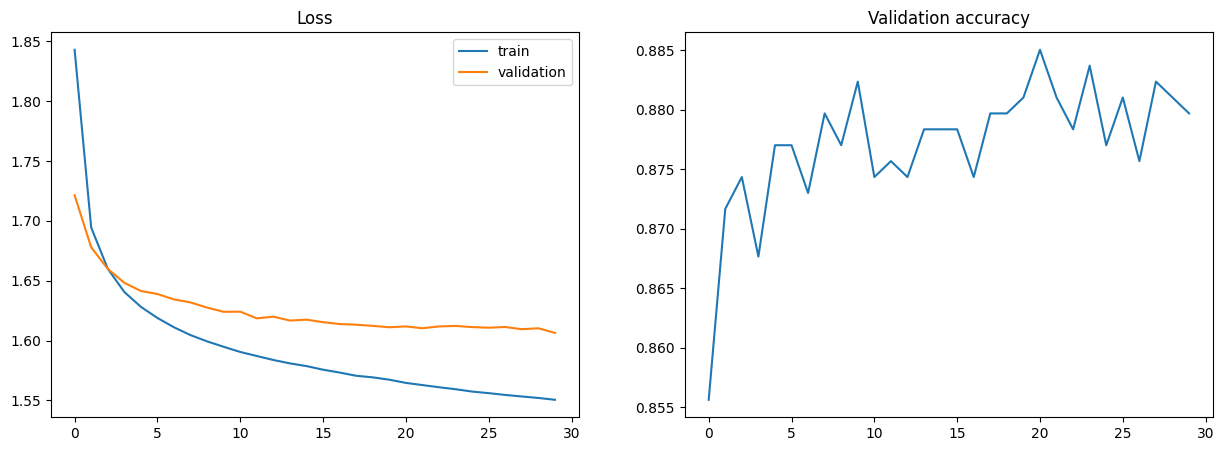

In [49]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [53]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [54]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.978s
	  training loss: 2.062617
	validation loss: 1.818155
	validation accuracy: 0.832
Epoch 2 of 30 took 0.724s
	  training loss: 1.721762
	validation loss: 1.665050
	validation accuracy: 0.876
Epoch 3 of 30 took 0.783s
	  training loss: 1.644878
	validation loss: 1.626284
	validation accuracy: 0.890
Epoch 4 of 30 took 0.731s
	  training loss: 1.609612
	validation loss: 1.599944
	validation accuracy: 0.898
Epoch 5 of 30 took 0.726s
	  training loss: 1.585893
	validation loss: 1.588945
	validation accuracy: 0.900
Epoch 6 of 30 took 0.704s
	  training loss: 1.570124
	validation loss: 1.575138
	validation accuracy: 0.904
Epoch 7 of 30 took 0.718s
	  training loss: 1.558427
	validation loss: 1.570282
	validation accuracy: 0.904
Epoch 8 of 30 took 0.680s
	  training loss: 1.549638
	validation loss: 1.567663
	validation accuracy: 0.905
Epoch 9 of 30 took 0.672s
	  training loss: 1.541838
	validation loss: 1.565652
	validation accuracy: 0.913
Epoch 10 of 30 took 0.731s
	

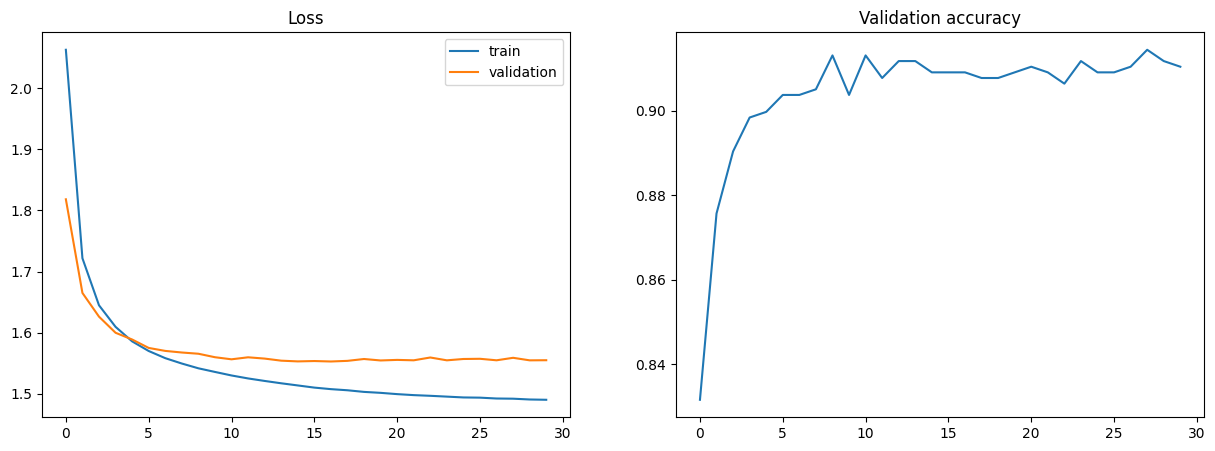

In [55]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

### Batchnorm try

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test()

#### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
!ls mnist*.pth

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('<CHECKPOINT NAME>', model, optimizer)
# should give you the final model accuracy
test()

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)